In [62]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from sklearn.cluster import KMeans

from gym import Env
from gym.utils import seeding

import tensorflow as tf
from keras import __version__
tf.keras.__version__ = __version__
from imp import reload
import json
import json
import matplotlib.pyplot as plt

import time
import random
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output

from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten, Embedding, Reshape
from keras.layers import Dense, Input, Flatten, Dropout, BatchNormalization
from keras.models import Model
from keras.optimizers import Adam
from rl.agents.dqn import DQNAgent
from rl.policy import BoltzmannQPolicy, EpsGreedyQPolicy, LinearAnnealedPolicy
from rl.memory import SequentialMemory
from keras.src.saving import serialization_lib
serialization_lib.enable_unsafe_deserialization()
from tensorflow.keras.optimizers.legacy import Adam
from rl.callbacks import FileLogger, ModelIntervalCheckpoint
from rl.callbacks import TestLogger

from rl.agents.dqn import DQNAgent
from rl.policy import EpsGreedyQPolicy
from rl.memory import SequentialMemory

In [63]:
load = pd.read_csv('../Data/load.csv')
load['date'] = pd.to_datetime(load['date'], format='%Y-%m-%d %H:%M:%S')
prices = pd.read_csv('../Data/prices.csv')
prices['date'] = pd.to_datetime(prices['date'], format='%Y-%m-%d %H:%M:%S')
res_gen = pd.read_csv('../Data/res_gen.csv')
res_gen['date'] = pd.to_datetime(res_gen['date'], format='%Y-%m-%d %H:%M:%S')
#residual_generation = pd.read_csv('../Data/residual_generation.csv')
industrial_demand = pd.read_csv('../Data/industrial_demand.csv')
industrial_demand['date'] = pd.to_datetime(industrial_demand['date'], format='%Y-%m-%d %H:%M:%S')

#create a Df with a date column with 24 hours for each day from 1.1.2019 until 31.12.2023
date = pd.DataFrame()
date['date'] = pd.date_range(start='2019-01-01', end='2024-01-01', freq='H')
#group by date and count the hours
date['hour'] = date['date'].dt.hour
date['day'] = date['date'].dt.day
date['month'] = date['date'].dt.month
date['year'] = date['date'].dt.year
date['weekday'] = date['date'].dt.weekday

#drop last row
date = date[:-1]

#merge them all on date
data = pd.merge(date, load, on='date', how='left')
data = pd.merge(data, prices, on='date', how='left')
data = pd.merge(data, res_gen, on='date', how='left')
#data = pd.merge(data, residual_generation, on='date')
data = pd.merge(data, industrial_demand, on='date', how='left')

#drop price_FRA
data = data.drop(columns=['price_FRA'])
help_data = pd.DataFrame()
help_data['date'] = pd.to_datetime(data['date'], format='%Y-%m-%d %H:%M:%S')
help_data['industrial_demand'] = data['industrial_demand']

#drop all columns without GER in the name
data = data[data.columns[data.columns.str.contains('GER')]]
data['date'] = help_data['date']
data['industrial_demand'] = help_data['industrial_demand']
data['year'] = data['date'].dt.year
data['month'] = data['date'].dt.month
data['day'] = data['date'].dt.day
data['hour'] = data['date'].dt.hour
data['weekday'] = data['date'].dt.weekday

#replace n/e with np.NaN
data = data.replace('n/e', np.NaN)
data = data.ffill()
# drop 29.02.2020
data = data[~((data['year'] == 2020) & (data['month'] == 2) & (data['day'] == 29))]

print(data.isnull().sum())

data.to_csv('data.csv', index=False)

load_GER                    0
price_GER                   0
solar_forecastGER           0
windoffshore_forecastGER    0
windonshore_forecastGER     0
date                        0
industrial_demand           0
year                        0
month                       0
day                         0
hour                        0
weekday                     0
dtype: int64


# Descriptive analysis

## Load

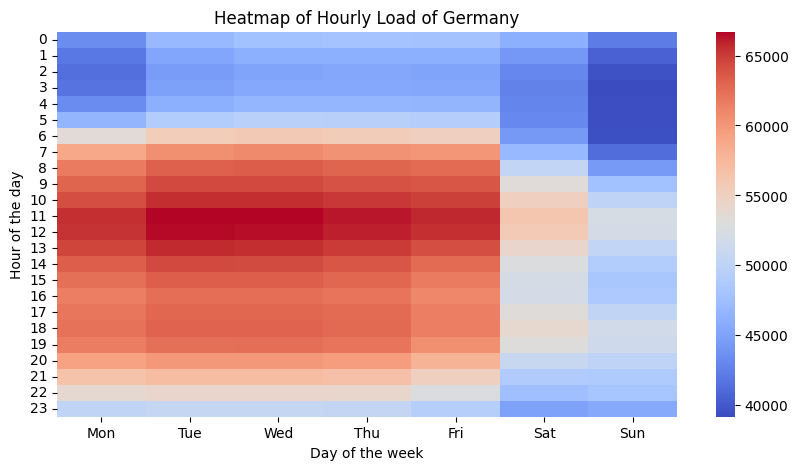

In [64]:
load_pivot = data.pivot_table(index='hour', columns='weekday', values='load_GER', aggfunc='mean')

fig, ax = plt.subplots(figsize=(10, 5))
sns.heatmap(load_pivot, cmap='coolwarm', ax=ax)

ax.set_title('Heatmap of Hourly Load of Germany')
ax.set_xlabel('Day of the week')
ax.set_ylabel('Hour of the day')
ax.set_xticklabels(['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])
plt.show()

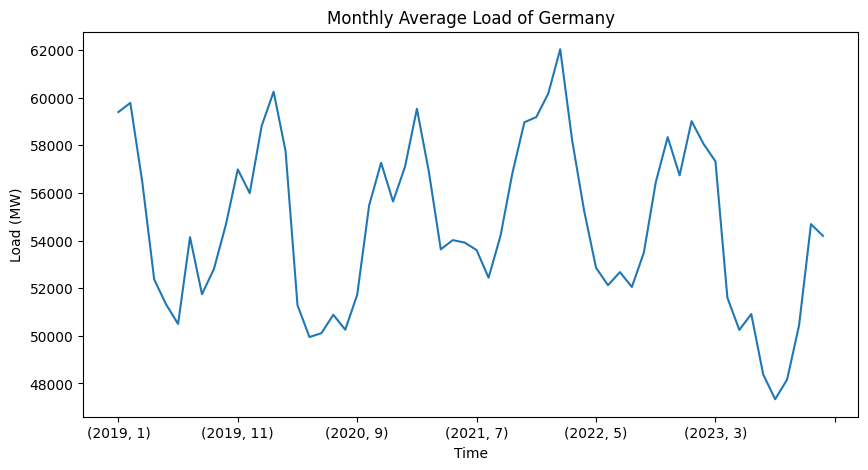

In [65]:
#group data to a yearly and monthly level
yearly_monthly_data = data.groupby(['year', 'month']).mean()

#plot the monthly average load
fig, ax = plt.subplots(figsize=(10, 5))
yearly_monthly_data['load_GER'].plot(ax=ax)
ax.set_title('Monthly Average Load of Germany')
ax.set_xlabel('Time')
ax.set_ylabel('Load (MW)')
plt.show()

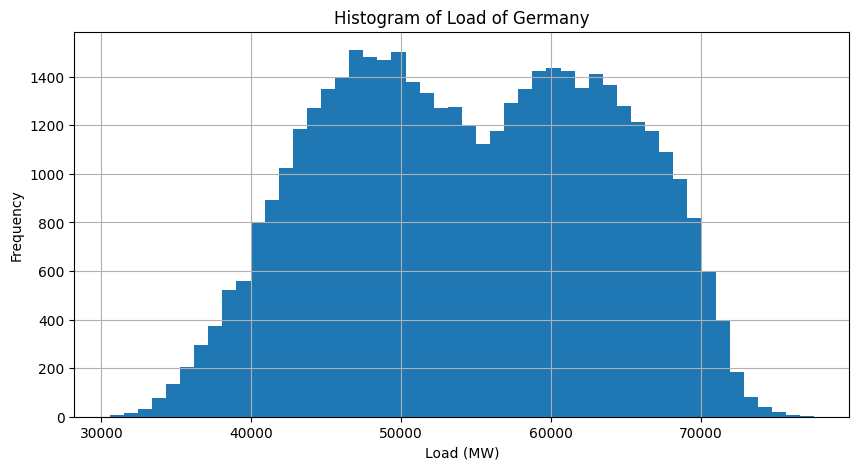

In [66]:
#make histogram of the load
fig, ax = plt.subplots(figsize=(10, 5))
data['load_GER'].hist(ax=ax, bins=50)
ax.set_title('Histogram of Load of Germany')
ax.set_xlabel('Load (MW)')
ax.set_ylabel('Frequency')
plt.show()

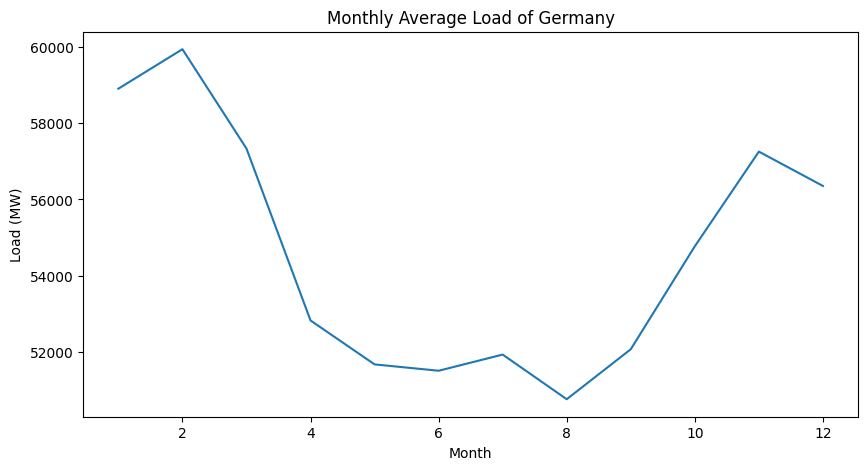

In [67]:
#group data to monthly level
monthly_data = data.groupby(['month']).mean()

#plot the monthly average load
fig, ax = plt.subplots(figsize=(10, 5))
monthly_data['load_GER'].plot(ax=ax)
ax.set_title('Monthly Average Load of Germany')
ax.set_xlabel('Month')
ax.set_ylabel('Load (MW)')
plt.show()

## Renewable generation

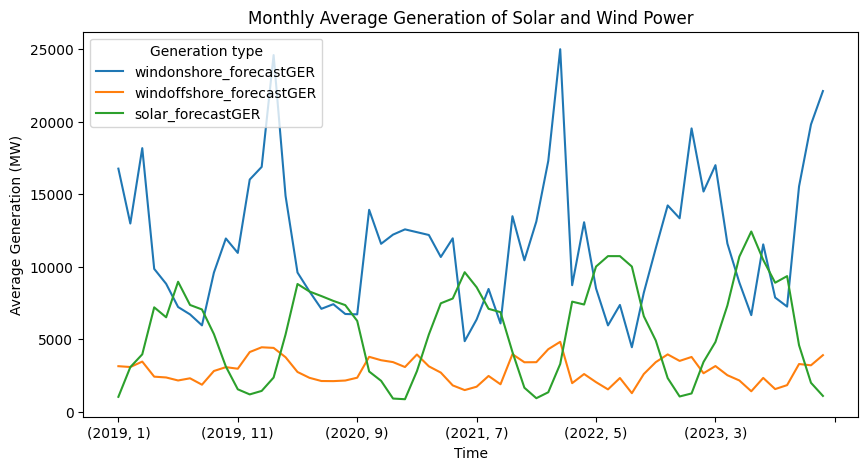

In [68]:
#plot the monthly average load
fig, ax = plt.subplots(figsize=(10, 5))
yearly_monthly_data['windonshore_forecastGER'].plot(ax=ax)
yearly_monthly_data['windoffshore_forecastGER'].plot(ax=ax)
yearly_monthly_data['solar_forecastGER'].plot(ax=ax)
ax.set_title('Monthly Average Generation of Solar and Wind Power')
ax.set_xlabel('Time')
ax.set_ylabel('Average Generation (MW)')
plt.legend(title='Generation type')
plt.show()

## Prices and correlations

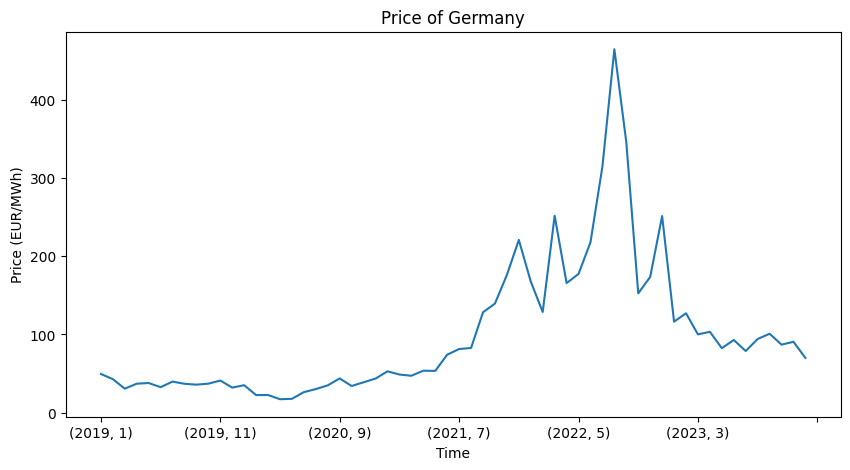

In [69]:
# plot prices
fig, ax = plt.subplots(figsize=(10, 5))
yearly_monthly_data['price_GER'].plot(ax=ax)
ax.set_title('Price of Germany')
ax.set_xlabel('Time')
ax.set_ylabel('Price (EUR/MWh)')
plt.show()

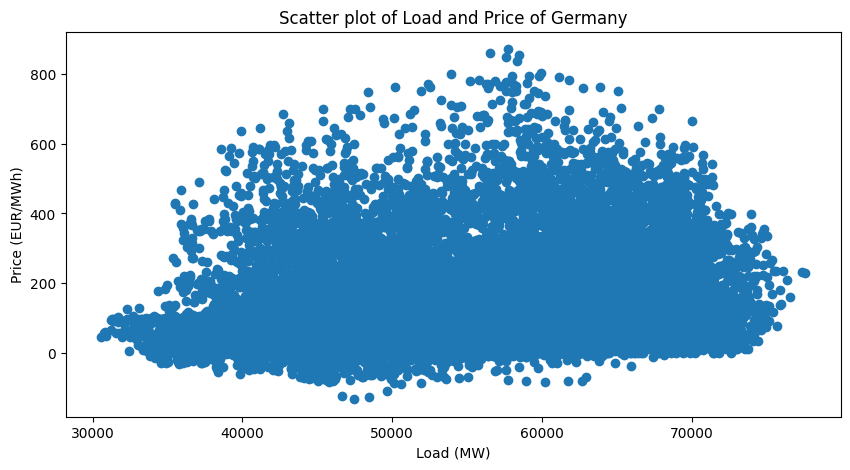

In [70]:
#scatter plot for load and price
fig, ax = plt.subplots(figsize=(10, 5))
ax.scatter(data['load_GER'], data['price_GER'])
ax.set_title('Scatter plot of Load and Price of Germany')
ax.set_xlabel('Load (MW)')
ax.set_ylabel('Price (EUR/MWh)')
plt.show()

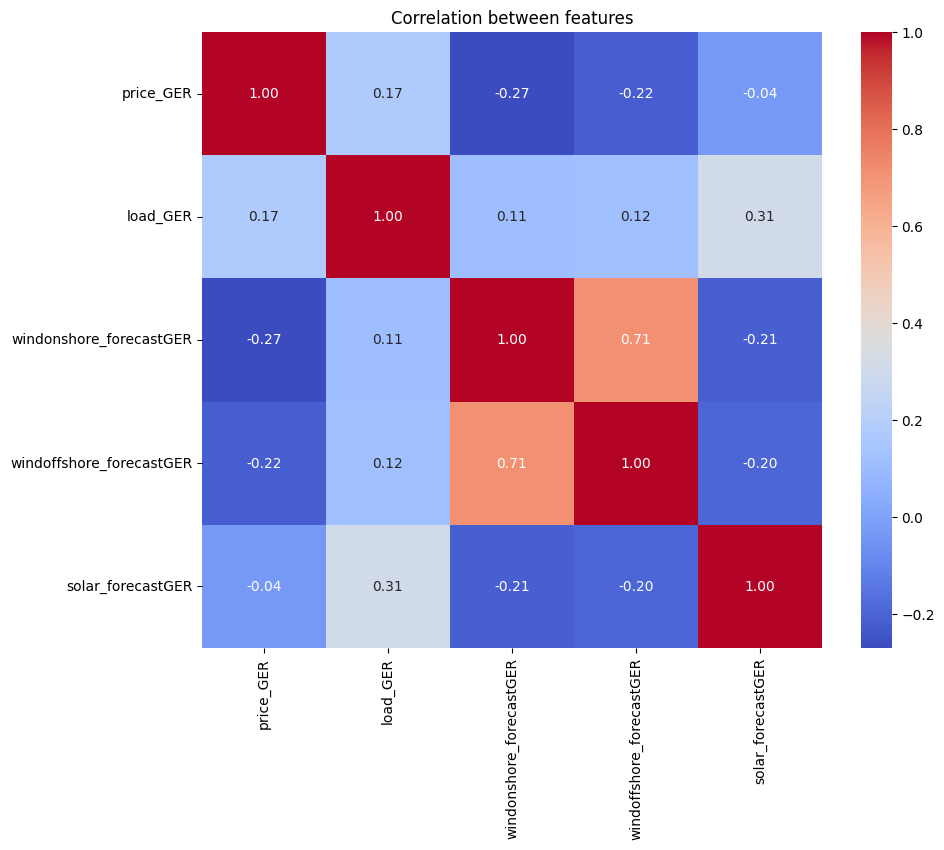

In [71]:
# Correlation Heatmap Between Load and Price
data_corr = data[['price_GER', 'load_GER', 'windonshore_forecastGER', 'windoffshore_forecastGER', 'solar_forecastGER']].corr()
plt.figure(figsize=(10, 8))
sns.heatmap(data_corr, annot=True, cmap='coolwarm', fmt=".2f")

plt.title('Correlation between features')
plt.show()

# Action plan generation

In [72]:
# create a df with one column for each hour and one row for each day
prices_df = data[['price_GER', 'date', 'hour', 'day']].copy()
# drop time from date column
prices_df['date'] = prices_df['date'].dt.date
#prices_df['date'] = pd.to_datetime(prices_df['date'])

prices_tab = prices_df.pivot(index='date',columns='hour', values='price_GER')
prices_tab = prices_tab.dropna()

# Make sure that each rows has a mean of 0 and a standard deviation of 1
prices_tab = prices_tab.apply(lambda x: (x - x.mean()) / x.std(), axis=1)
prices_df = pd.DataFrame(prices_tab, index=prices_tab.index, columns=prices_tab.columns)

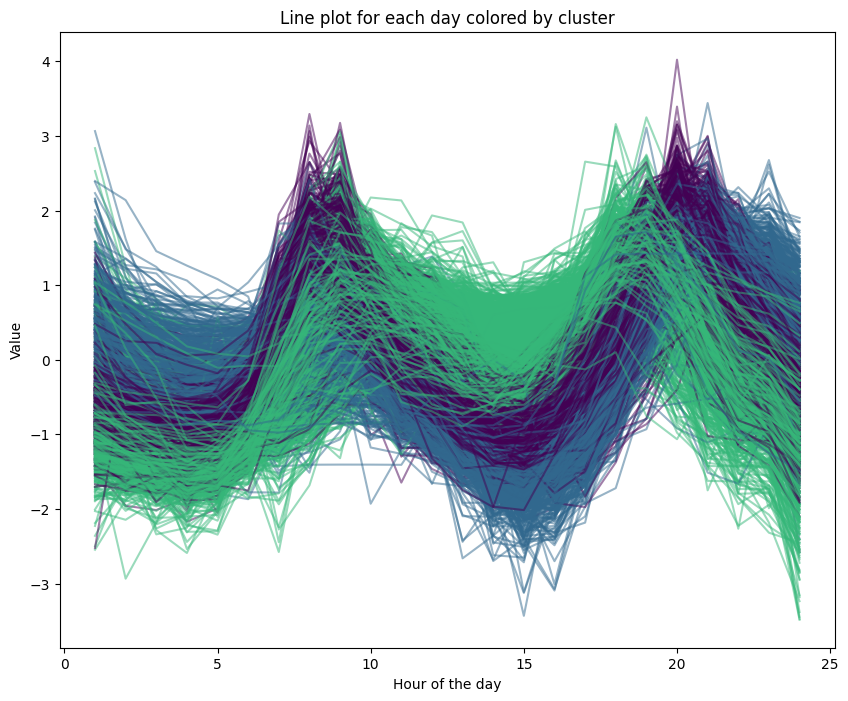

In [73]:
n_clusters=3

kmeans = KMeans(n_clusters=n_clusters, random_state=0, n_init=10, max_iter=1000)
kmeans.fit(prices_df.iloc[:, :24])
prices_df['cluster'] = kmeans.labels_

# Assuming the columns representing hours are named as 'H1', 'H2', ..., 'H24'
hours = range(1, 25)

plt.figure(figsize=(10, 8))

# Plot a line for each day
for i in range(prices_df.shape[0]):
    plt.plot(hours, prices_df.iloc[i, :24], color=plt.cm.viridis(prices_df.iloc[i, -1]/3), alpha=0.5)

plt.xlabel('Hour of the day')
plt.ylabel('Value')
plt.title('Line plot for each day colored by cluster')
plt.show()

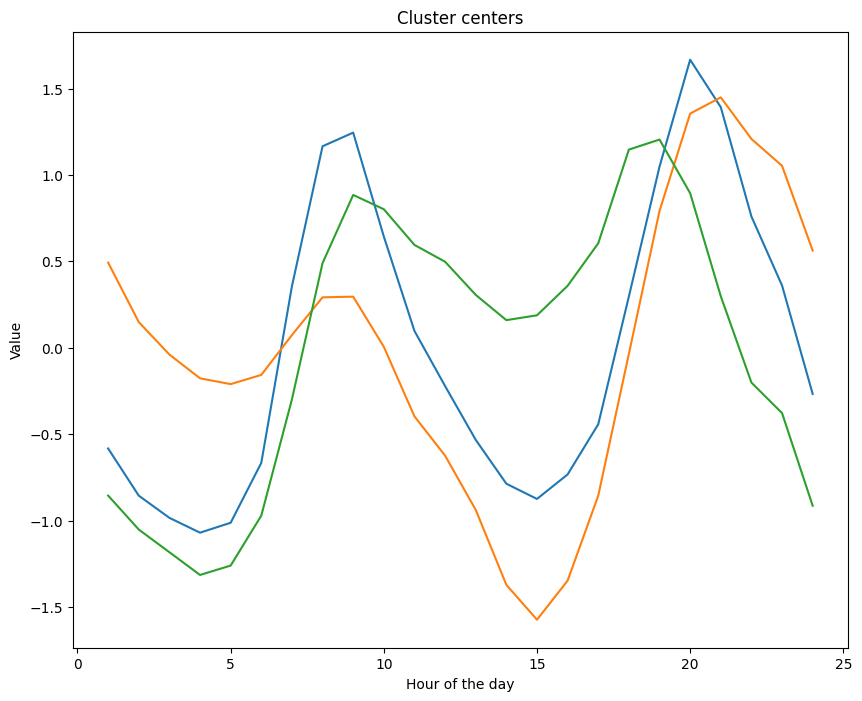

In [74]:
#plot kmeans.cluster_centers_
plt.figure(figsize=(10, 8))
plt.plot(hours, kmeans.cluster_centers_.T)
plt.xlabel('Hour of the day')
plt.ylabel('Value')
plt.title('Cluster centers')
plt.show()

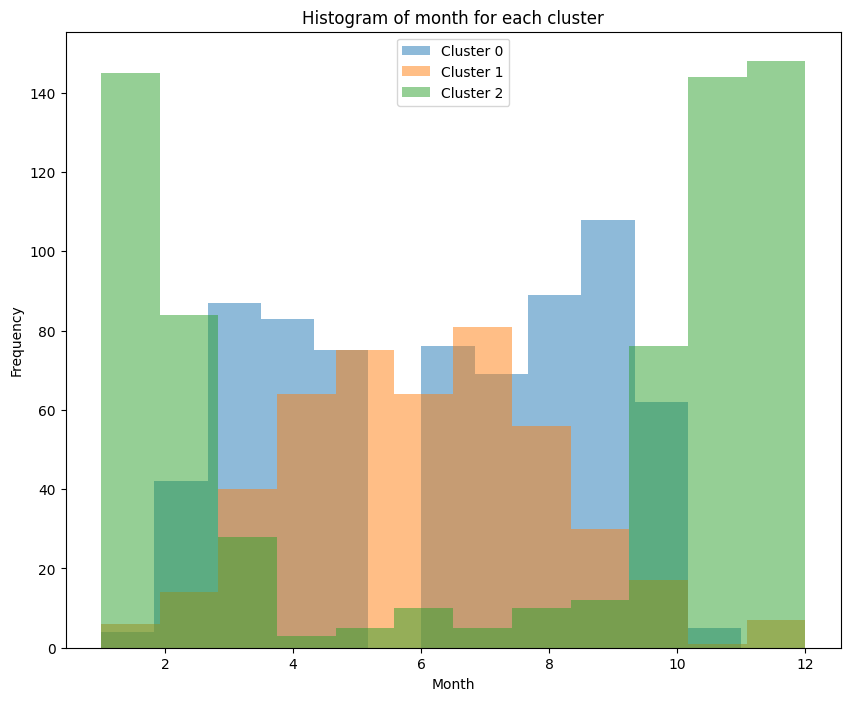

In [75]:
prices_df['month'] = pd.to_datetime(prices_df.index).month
prices_df['weekday'] = pd.to_datetime(prices_df.index).weekday

# make a histogram for each cluster for the month column and weekday column
plt.figure(figsize=(10, 8))
for i in range(n_clusters):
    plt.hist(prices_df[prices_df['cluster'] == i]['month'], alpha=0.5, label='Cluster {}'.format(i), bins=12)
plt.xlabel('Month')
plt.ylabel('Frequency')
plt.title('Histogram of month for each cluster')
plt.legend()
plt.show()

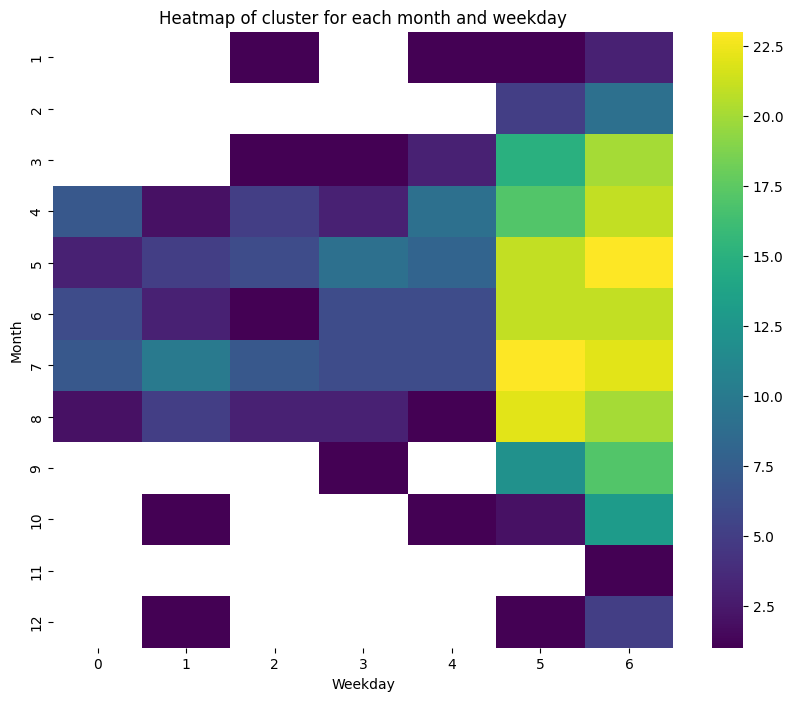

In [76]:
# make a sns heatmap with weekday and month on the x and y axis and the cluster as the color
heatmap_data = prices_df[prices_df['cluster'] == 1].pivot_table(index='month', columns='weekday', values='cluster', aggfunc='count')
import seaborn as sns
plt.figure(figsize=(10, 8))
sns.heatmap(heatmap_data, cmap='viridis')
plt.xlabel('Weekday')
plt.ylabel('Month')
plt.title('Heatmap of cluster for each month and weekday')
plt.show()

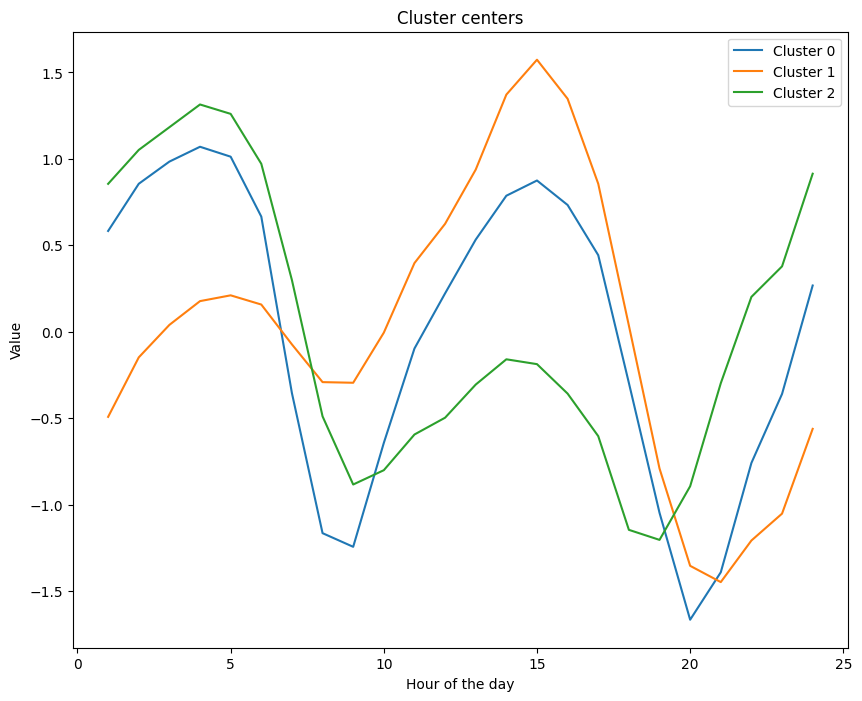

In [77]:
# invert the centroids
centroids = kmeans.cluster_centers_*-1
#divide positive values by max positive value and negative values by max negative value
# for i in range(n_clusters):
#     max_pos = centroids[i][centroids[i]>0].max()
#     max_neg = centroids[i][centroids[i]<0].min()*-1
#     centroids[i][centroids[i]>0] = centroids[i][centroids[i]>0]/max_pos
#     centroids[i][centroids[i]<0] = centroids[i][centroids[i]<0]/max_neg
#     print(centroids[i].mean())

plt.figure(figsize=(10, 8))
plt.plot(hours, centroids.T)
plt.xlabel('Hour of the day')
plt.ylabel('Value')
plt.title('Cluster centers')
plt.legend(['Cluster 0', 'Cluster 1', 'Cluster 2'])
plt.show()

In [78]:
action_4 = centroids[0].copy()
action_4[action_4>0] = 1
action_4[action_4<0] = -1

action_5 = centroids[1].copy()
action_5[action_5>0] = 1
action_5[action_5<0] = -1

action_6 = centroids[2].copy()
action_6[action_6>0] = 1
action_6[action_6<0] = -1

In [79]:
#make a dictonary with all the action plans
action_plans_help = {
    0: centroids[0],
    1: centroids[1],
    2: centroids[2],
    3: [0]*24,
    4: action_4,
    5: action_5,
    6: action_6,
    7: action_6*-1
}

keys = list(action_plans_help.keys())

action_plans = {}

for i in range(len(action_plans_help)):
    action_plans[i] = action_plans_help[keys[i]]

#save action plans to csv
action_plans_df = pd.DataFrame.from_dict(action_plans)
action_plans_df.to_csv('action_plans.csv', index=False)

# Environment class

In [80]:
class BatteryManagementEnv(Env):

    def __init__(self, start_day=0):
        #self.charge_level = 50  # Initial battery charge level
        self.start_day = start_day
        self.action_space = 1  # 24-hour action vector with actions -1, 0, or 1
        self.observation_space = 99  # Battery charge level as a float
        self.max_episode_len = 365  # Maximum number of steps in an episode
        self.n_episodes = -1

        # Set other needed variables like the charge rate, discharge rate, etc.
        self.charge_rate = 5  # Amount of charge to increase per step when charging
        self.discharge_rate = 5  # Amount of charge to decrease per step when discharging
        self.max_charge = 100  # Maximum battery charge level
        self.min_charge = 0 # Minimum battery charge level

        self.nA = action_plans.shape[1]

        self.soc_df = pd.DataFrame()
        self.actions_df = pd.DataFrame()
        self.prices_df = pd.DataFrame()
        self.demand_df = pd.DataFrame()
        self.dates_df = pd.DataFrame()
        self.penalty_df = pd.DataFrame()

        self.seed()
        self.reset()

    def seed(self, seed=None):
        self.np_random, seed = seeding.np_random(seed)
        return [seed]

    def reset(self):
        # Reset the state of the environment to an initial state
        self.t = 0
        self.year = random.randint(2019, 2023)
        self.data_year = data[data['year'] == self.year].reset_index(drop=True)
        self.charge_level = 10  # Or some other logic to determine initial charge level
        self.n_episodes += 1
        

        self.soc_list = []
        self.actions = []
        self.prices = []
        self.demand = []
        self.dates = []
        self.penalties = []

        input = self.get_input_data(0)

        self.state = np.array([self.charge_level]+input)
        self.lastaction = None
        self.lastreward = None

        self.total_reward = 0

        return self.state
    
    def get_date(self, day):
        return list(self.data_year['date'][day*24:day*24+24])
    
    def get_prices(self, day):
        return list(self.data_year['price_GER'][day*24:day*24+24])
    
    def get_input_data(self, day):
        input_array = list(self.data_year['solar_forecastGER'][day*24:day*24+24])
        input_array += list(self.data_year['windonshore_forecastGER'][day*24:day*24+24])
        input_array += list(self.data_year['windoffshore_forecastGER'][day*24:day*24+24])
        input_array += list(self.data_year['load_GER'][day*24:day*24+24])
        input_array += list(self.data_year['month'].iloc[[day*24]])
        input_array += list(self.data_year['weekday'].iloc[[day*24]])

        return input_array
    
    def get_industrial_demand(self, day):
        return list(self.data_year['industrial_demand'][day*24:day*24+24])
    
    def step(self, action):
        self.lastaction = action

        prices = self.get_prices(self.t)
        input = self.get_input_data(self.t)
        industrial_demand = self.get_industrial_demand(self.t)
        dates = self.get_date(self.t)
        self.state[1:] = input

        #add each element of price of the day to the prices list
        for i in range(len(prices)):
            self.prices.append(prices[i])
            self.demand.append(industrial_demand[i])
            self.dates.append(dates[i])

        done= False

        # Initialize an empty dictionary to store the column data
        action_dict = {}

        # Loop over the columns in the DataFrame
        for i in range(action_plans.shape[1]):
            # Store the column data in the dictionary
            action_dict[i] = list(action_plans.iloc[:, i])


        selected_action = action_dict[action]
        daily_cost = 0

        

        for hour in range(24):
            cost = 0
            if selected_action[hour] > 0:  # charge
                new_charge_level = self.state[0] + self.charge_rate*selected_action[hour]
                if new_charge_level <= self.max_charge:
                    self.state[0] = new_charge_level
                    self.actions.append(selected_action[hour])
                    self.penalties.append(0)
                    cost += (self.charge_rate*selected_action[hour] + industrial_demand[hour])*prices[hour]
                else:
                    cost += (1.2*self.charge_rate*selected_action[hour] + industrial_demand[hour])*prices[hour]  # Penalty for trying to overcharge
                    self.penalties.append(1)
                    self.actions.append(0)

            elif selected_action[hour] < 0:  # discharge
                new_charge_level = self.state[0] + self.discharge_rate*selected_action[hour]
                if new_charge_level >= self.min_charge:
                    self.state[0] = new_charge_level
                    self.actions.append(selected_action[hour])
                    self.penalties.append(0)
                    cost += (self.discharge_rate*selected_action[hour] + industrial_demand[hour])*prices[hour]
                else:
                    self.actions.append(0)
                    self.penalties.append(1)
                    cost += (-1.2* self.discharge_rate*selected_action[hour] + industrial_demand[hour])*prices[hour]  # Penalty for trying to overdischarge

            elif selected_action[hour] == 0:  # do nothing
                cost += industrial_demand[hour]*prices[hour]
                self.actions.append(0)
                self.penalties.append(0)

            daily_cost += cost
            self.soc_list.append(self.state[0])

        daily_reward = (sum([a*b for a,b in zip(prices, industrial_demand)]) - daily_cost)
        self.total_reward += daily_reward
        self.lastreward = daily_reward
        self.t += 1

        if self.t>= self.max_episode_len:
            self.soc_df[self.n_episodes] = self.soc_list
            self.actions_df[self.n_episodes] = self.actions
            self.prices_df[self.n_episodes] = self.prices
            self.demand_df[self.n_episodes] = self.demand
            self.dates_df[self.n_episodes] = self.dates
            self.penalty_df[self.n_episodes] = self.penalties
            
            self.soc_df.to_csv('results/soc_df.csv')
            self.actions_df.to_csv('results/actions_df.csv')
            self.prices_df.to_csv('results/prices_df.csv')
            self.demand_df.to_csv('results/demand_df.csv')
            self.dates_df.to_csv('results/dates_df.csv')
            self.penalty_df.to_csv('results/penalty_df.csv')
            
            return (self.state, daily_reward, True, {})  # (nextstate, reward, done, info)
        
        done = False
        info = {}  # Additional information

        return self.state, daily_reward, done, info

## Neural network

In [81]:
def build_enhanced_model(states, actions):
    # Define the input layer
    input_layer = Input(shape=(1,states))  # Adjusted for a flat input vector

    # Flatten the input if it's multidimensional
    if len(input_layer.shape) > 2:
        x = Flatten()(input_layer)
    else:
        x = input_layer

    # First hidden layer
    x = Dense(32, activation='relu')(x)
    #x = BatchNormalization()(x)  # Batch normalization layer
    x = Dropout(0.2)(x)  # Dropout layer

    x= Dense(64, activation='relu')(x)
    #x = BatchNormalization()(x)
    x = Dropout(0.2)(x)

    # Second hidden layer
    x = Dense(32, activation='relu')(x)
    #x = BatchNormalization()(x)
    x = Dropout(0.2)(x)

    # Output layer
    output = Dense(actions, activation='linear')(x)

    # Create the Keras Model
    model = Model(inputs=input_layer, outputs=output)
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')

    return model

In [82]:
def plot_training_progress(log_filename):
    # Open the log file and load the data
    with open(log_filename, 'r') as file:
        data = json.load(file)
    
    # Assuming 'episode_reward' and 'loss' are keys in your logged data
    # Ensure these keys align with how you've structured your log outputs
    rewards = data.get('episode_reward', [])
    losses = data.get('loss', [])
    nb_episodes = len(rewards)
    
    # Create a plot with two subplots: one for rewards and one for losses
    fig, axs = plt.subplots(2, 1, figsize=(10, 10))
    
    # Plotting the rewards
    axs[0].plot(rewards, label='Episode Rewards')
    axs[0].set_xlabel('Episodes')
    axs[0].set_ylabel('Reward')
    axs[0].set_title('Rewards per Episode')
    axs[0].legend()
    
    # Plotting the losses, if available
    if losses:
        axs[1].plot(losses, label='Loss per Step', color='red')
        axs[1].set_xlabel('Steps')
        axs[1].set_ylabel('Loss')
        axs[1].set_title('Training Loss over Steps')
        axs[1].legend()
    
    # Show the plot
    plt.tight_layout()
    plt.show()

In [83]:
data = pd.read_csv('data.csv')
prices = data[['price_GER']]
industrial_demand = data[['industrial_demand']]
action_plans = pd.read_csv('../final_project/action_plans.csv', header=0)

env = BatteryManagementEnv(0)
model = build_enhanced_model(env.observation_space, env.nA)

In [84]:
# Then, define DQN agent in Keras-RL
memory = SequentialMemory(limit=20000, window_length=1)
policy = LinearAnnealedPolicy(EpsGreedyQPolicy(eps=0.005), 
                              attr='eps', value_max=1., value_min=.1, value_test=.05, nb_steps=10000)
dqn = DQNAgent(model=model, nb_actions=env.nA, memory=memory, policy=policy,
                nb_steps_warmup=500, target_model_update=1e-2, enable_double_dqn=True, enable_dueling_network=True)
dqn.compile(optimizer=Adam(learning_rate=1e-3), metrics=['mae'])

Training for 54750 steps ...
Interval 1 (0 steps performed)
  1/365 [..............................] - ETA: 1:11 - reward: 143.2819

c:\Users\janle\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


365/365 [==============================] - 1s 2ms/step - reward: 164.0785
1 episodes - episode_reward: 59888.640 [59888.640, 59888.640]

Interval 2 (365 steps performed)
365/365 [==============================] - 3s 9ms/step - reward: 153.9633
1 episodes - episode_reward: 56196.610 [56196.610, 56196.610] - loss: 12656573.544 - mae: 4562.870 - mean_q: 7488.631 - mean_eps: 0.945

Interval 3 (730 steps performed)
365/365 [==============================] - 3s 7ms/step - reward: 475.0558
1 episodes - episode_reward: 173395.373 [173395.373, 173395.373] - loss: 2000377.959 - mae: 3478.601 - mean_q: 5185.051 - mean_eps: 0.918

Interval 4 (1095 steps performed)
365/365 [==============================] - 3s 7ms/step - reward: 675.5942
1 episodes - episode_reward: 246591.899 [246591.899, 246591.899] - loss: 1406889.646 - mae: 2494.091 - mean_q: 3715.586 - mean_eps: 0.885

Interval 5 (1460 steps performed)
365/365 [==============================] - 2s 7ms/step - reward: 499.9677
1 episodes - episo

C:\Users\janle\AppData\Local\Temp\ipykernel_21212\3902228674.py:149: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.soc_df[self.n_episodes] = self.soc_list
C:\Users\janle\AppData\Local\Temp\ipykernel_21212\3902228674.py:150: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.actions_df[self.n_episodes] = self.actions
C:\Users\janle\AppData\Local\Temp\ipykernel_21212\3902228674.py:151: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performan

365/365 [==============================] - 5s 14ms/step - reward: 3218.4437
1 episodes - episode_reward: 1174731.933 [1174731.933, 1174731.933] - loss: 2242676.670 - mae: 3440.445 - mean_q: 5041.176 - mean_eps: 0.100

Interval 102 (36865 steps performed)
365/365 [==============================] - 5s 14ms/step - reward: 1478.4691
1 episodes - episode_reward: 539641.232 [539641.232, 539641.232] - loss: 2399356.467 - mae: 3385.492 - mean_q: 5016.659 - mean_eps: 0.100

Interval 103 (37230 steps performed)
365/365 [==============================] - 5s 14ms/step - reward: 3570.6574
1 episodes - episode_reward: 1303289.936 [1303289.936, 1303289.936] - loss: 2442950.265 - mae: 3483.989 - mean_q: 5159.419 - mean_eps: 0.100

Interval 104 (37595 steps performed)
365/365 [==============================] - 5s 14ms/step - reward: 547.8907
1 episodes - episode_reward: 199980.109 [199980.109, 199980.109] - loss: 2650465.929 - mae: 3735.359 - mean_q: 5562.913 - mean_eps: 0.100

Interval 105 (37960 step

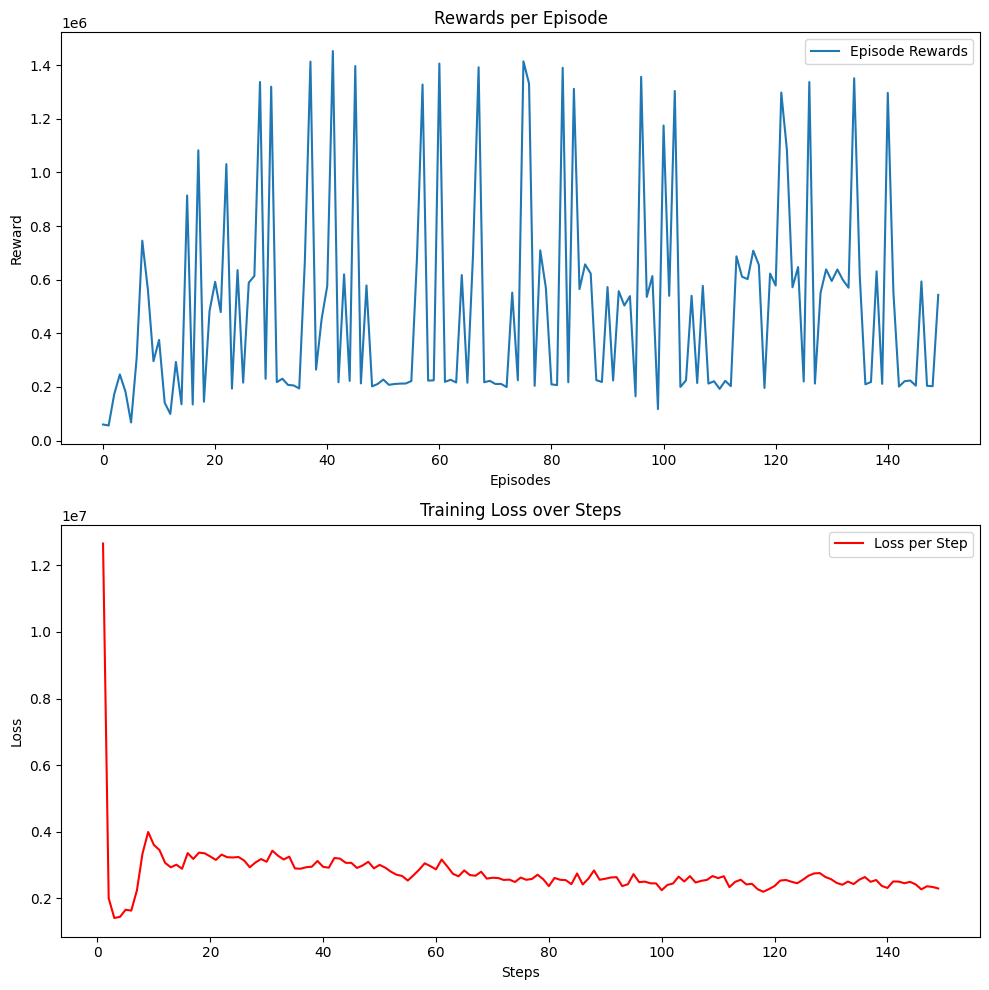

In [85]:
nb_max_episode_steps = 365
nb_steps = nb_max_episode_steps*150
log_filename = 'results/dqn_BatteryManagementEnv_log.json'
logger = FileLogger(log_filename, interval=nb_max_episode_steps)


dqn.fit(env, nb_steps=nb_steps, visualize=False, verbose=1, nb_max_episode_steps=nb_max_episode_steps, log_interval=nb_max_episode_steps,callbacks=[logger])

# Call the function with the path to your log file
plot_training_progress('results/dqn_BatteryManagementEnv_log.json')

In [86]:
#load results files and plot the results
soc_df = pd.read_csv('results/soc_df.csv', index_col=0)
actions_df = pd.read_csv('results/actions_df.csv', index_col=0)
prices_df = pd.read_csv('results/prices_df.csv', index_col=0)
demand_df = pd.read_csv('results/demand_df.csv', index_col=0)
dates_df = pd.read_csv('results/dates_df.csv', index_col=0)
penalty_df = pd.read_csv('results/penalty_df.csv', index_col=0)

result_dict = {}
best_day = {}

for i in range(soc_df.shape[1]):
    key = str(i+1)
    result_df = pd.concat([dates_df[key], demand_df[key], actions_df[key], prices_df[key], soc_df[key], penalty_df[key]], axis=1)
    result_df.columns = ['date', 'demand', 'action', 'price', 'soc', 'penalty']
    result_df['charge'] = result_df['action']*5
    result_df['demand_costs'] = result_df['demand']*result_df['price']
    result_df['charge_costs'] = result_df['charge']*result_df['price']
    result_df['total_costs'] = result_df['demand_costs'] + result_df['charge_costs']
    result_df['savings'] = result_df['demand_costs'] - result_df['total_costs']
    result_df['fee'] = 1.2*result_df['penalty']*result_df['price']

    result_df['date'] = pd.to_datetime(result_df['date'])
    result_df = result_df.set_index('date')
    #groupby day and sum the savings
    daily_result_df = result_df.groupby(result_df.index.date).sum()
    #change index to column
    daily_result_df['date'] = daily_result_df.index
    daily_result_df.reset_index(drop=True, inplace=True)
    #return index with highest savings and no penalties
    max_saving = daily_result_df[(daily_result_df['price'] >= 0) & (daily_result_df['penalty'] == 0)]['savings'].idxmax()
    best_day[i] = daily_result_df.iloc[max_saving]

    result_dict[i] = result_df

In [87]:
#select day which is in all best days
selected_day = best_day[0]
print(selected_day)
plot_df = result_dict[0].loc[result_dict[0].index.date == selected_day['date']]

plot_df['date'] = plot_df.index
plot_df.reset_index(drop=True, inplace=True)
plot_df['date'] = pd.to_datetime(plot_df['date'], format='%Y-%m-%d %H:%M:%S')
plot_df['hour'] = plot_df['date'].dt.hour

plot_df

demand           24645.056145
action                   -0.0
price                  344.44
soc                662.502868
penalty                     0
charge                   -0.0
demand_costs    351035.563668
charge_costs     -1910.615803
total_costs     349124.947865
savings           1910.615803
fee                       0.0
date               2019-08-11
Name: 222, dtype: object


C:\Users\janle\AppData\Local\Temp\ipykernel_21212\1800200555.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  plot_df['date'] = plot_df.index
C:\Users\janle\AppData\Local\Temp\ipykernel_21212\1800200555.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  plot_df['date'] = pd.to_datetime(plot_df['date'], format='%Y-%m-%d %H:%M:%S')
C:\Users\janle\AppData\Local\Temp\ipykernel_21212\1800200555.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[ro

,demand,action,price,soc,penalty,charge,demand_costs,charge_costs,total_costs,savings,fee,date,hour
0,1044.014930,-0.492934,24.96,17.475139,0,-2.464671,26058.612659,-61.518181,25997.094478,61.518181,0.0,2019-08-11 00:00:00,0
1,1029.351522,-0.148692,18.58,16.731681,0,-0.743459,19125.351276,-13.813460,19111.537816,13.813460,0.0,2019-08-11 01:00:00,1
2,1016.441186,0.039365,14.55,16.928508,0,0.196827,14789.219258,2.863840,14792.083098,-2.863840,0.0,2019-08-11 02:00:00,2
3,1046.352019,0.176908,12.70,17.813046,0,0.884538,13288.670635,11.233635,13299.904270,-11.233635,0.0,2019-08-11 03:00:00,3
4,1008.251834,0.210359,13.13,18.864842,0,1.051795,13238.346574,13.810072,13252.156646,-13.810072,0.0,2019-08-11 04:00:00,4
5,1026.219925,0.157087,13.62,19.650275,0,0.785434,13977.115373,10.697609,13987.812982,-10.697609,0.0,2019-08-11 05:00:00,5
6,1007.330314,-0.073531,11.94,19.282619,0,-0.367657,12027.523943,-4.389821,12023.134123,4.389821,0.0,2019-08-11 06:00:00,6
7,1001.260785,-0.291836,9.20,17.823440,0,-1.459178,9211.599218,-13.424441,9198.174777,13.424441,0.0,2019-08-11 07:00:00,7
8,1043.227620,-0.295527,11.58,16.345807,0,-1.477634,12080.575839,-17.110999,12063.464841,17.110999,0.0,2019-08-11 08:00:00,8
9,1043.843529,-0.005523,9.48,16.318191,0,-0.027616,9895.636655,-0.261800,9895.374855,0.261800,0.0,2019-08-11 09:00:00,9


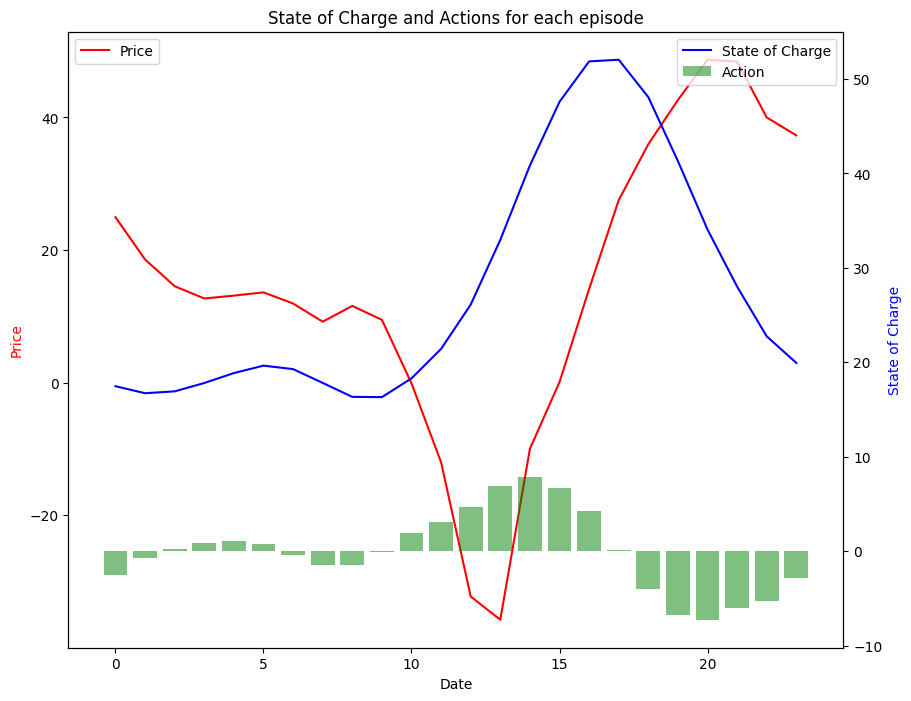

In [88]:
# Set figure size
fig, ax1 = plt.subplots(figsize=(10, 8))

# Plot state of charge on the primary axis
ax1.plot(plot_df['hour'], plot_df['price'], label='Price', color='red')
ax1.set_xlabel('Date')
ax1.set_ylabel('Price', color='red')

# Create a twin axis sharing the same x-axis
ax2 = ax1.twinx()

# Plot actions as bars on the secondary axis
ax2.bar(plot_df['hour'], plot_df['charge'], label='Action', color='green', alpha=0.5)
ax2.set_ylabel('Action', color='green')

# Plot state of charge on the primary axis
ax2.plot(plot_df['hour'], plot_df['soc'], label='State of Charge', color='blue')
ax2.set_xlabel('Hour')
ax2.set_ylabel('State of Charge', color='blue')

# Set title
plt.title('State of Charge and Actions for each episode')

# Add legend
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

# Display plot
plt.show()